# 神经网络工具箱

In [1]:
#数据准备
import numpy as np
import torch
# 导入 pytorch 内置的 mnist 数据
from torchvision.datasets import mnist
#import torchvision
#导入预处理模块
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#导入nn及优化器
import torch.nn.functional as F
import torch.optim as optim
from torch import nn


In [2]:
# 定义一些超参数
train_batch_size = 64
test_batch_size = 128
learning_rate = 0.01
num_epoches = 20

In [4]:
#定义预处理函数
transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize([0.5], [0.5])])
#定义预处理函数
transform = transforms.Compose(
[transforms.ToTensor(),
transforms.Normalize([0.5], [0.5])])
#下载数据，并对数据进行预处理
train_dataset = mnist.MNIST('./data',
train=True,
transform=transform,
download=True)
test_dataset = mnist.MNIST('./data', train=False, transform=transform)
#得到一个生成器
train_loader = DataLoader(train_dataset,
batch_size=train_batch_size,
shuffle=True)
test_loader = DataLoader(test_dataset,
batch_size=test_batch_size,
shuffle=False)

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([128, 1, 28, 28])

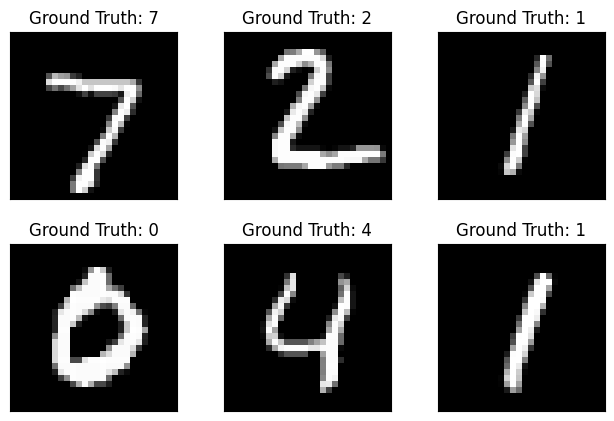

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])


In [7]:
#构建模型
class Net(nn.Module):
    """
    使用sequential构建网络，Sequential()函数的功能是将网络的层组合到一起
    """
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1),
        nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2),
        nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x


In [8]:
lr = 0.01
momentum = 0.9
#实例化模型
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#if torch.cuda.device_count() > 1:
# print("Let's use", torch.cuda.device_count(), "GPUs")
# # dim = 0 [20, xxx] -> [10, ...], [10, ...] on 2GPUs
# model = nn.DataParallel(model)
model = Net(28 * 28, 300, 100, 10)
model.to(device)
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)


In [9]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []
for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()
    #动态修改参数学习率
    if epoch % 5 == 0:
        optimizer.param_groups[0]['lr'] *= 0.9
        print(optimizer.param_groups[0]['lr'])
    for img, label in train_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        # 前向传播
        out = model(img)
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 保存loss的数据与epoch数值
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        train_acc += acc
    
    losses.append(train_loss / len(train_loader))
    acces.append(train_acc / len(train_loader))
    # 在测试集上检验效果
    eval_loss = 0
    eval_acc = 0
    #net.eval() # 将模型改为预测模式
    model.eval()
    for img, label in test_loader:
        img = img.to(device)
        label = label.to(device)
        img = img.view(img.size(0), -1)
        out = model(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]
        eval_acc += acc
    
    eval_losses.append(eval_loss / len(test_loader))
    eval_acces.append(eval_acc / len(test_loader))
    print(
    'epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
    .format(epoch, train_loss / len(train_loader),
    train_acc / len(train_loader), eval_loss / len(test_loader),
    eval_acc / len(test_loader)))

0.009000000000000001
epoch: 0, Train Loss: 0.2261, Train Acc: 0.9363, Test Loss: 0.0953, Test Acc: 0.9722
epoch: 1, Train Loss: 0.0897, Train Acc: 0.9730, Test Loss: 0.0723, Test Acc: 0.9783
epoch: 2, Train Loss: 0.0619, Train Acc: 0.9813, Test Loss: 0.0674, Test Acc: 0.9785
epoch: 3, Train Loss: 0.0458, Train Acc: 0.9858, Test Loss: 0.0611, Test Acc: 0.9818
epoch: 4, Train Loss: 0.0360, Train Acc: 0.9887, Test Loss: 0.0661, Test Acc: 0.9775
0.008100000000000001
epoch: 5, Train Loss: 0.0253, Train Acc: 0.9926, Test Loss: 0.0618, Test Acc: 0.9803
epoch: 6, Train Loss: 0.0195, Train Acc: 0.9945, Test Loss: 0.0578, Test Acc: 0.9814
epoch: 7, Train Loss: 0.0163, Train Acc: 0.9952, Test Loss: 0.0597, Test Acc: 0.9822
epoch: 8, Train Loss: 0.0143, Train Acc: 0.9961, Test Loss: 0.0561, Test Acc: 0.9826
epoch: 9, Train Loss: 0.0137, Train Acc: 0.9958, Test Loss: 0.0565, Test Acc: 0.9823
0.007290000000000001
epoch: 10, Train Loss: 0.0100, Train Acc: 0.9974, Test Loss: 0.0522, Test Acc: 0.9840
e

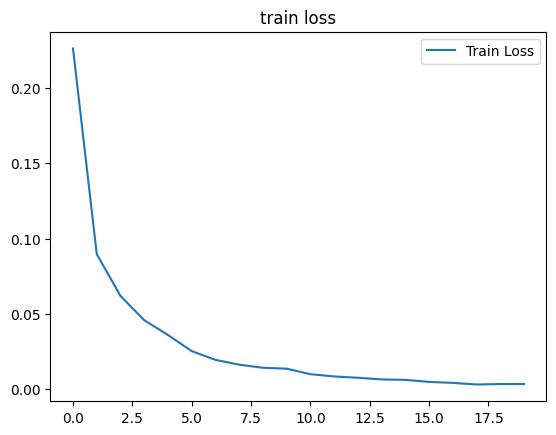

In [10]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
#plt.plot(np.arange(len(eval_losses)), eval_losses)
#plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.legend(['Train Loss'], loc='upper right')

In [11]:
#优化器
import torch
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
# 超参数
LR = 0.01
BATCH_SIZE = 32
EPOCH = 12
# 生成训练数据
# torch.unsqueeze() 的作用是将一维变二维，torch只能处理二维的数据
x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)
# 0.1 * torch.normal(x.size())增加噪点
y = x.pow(2) + 0.1 * torch.normal(torch.zeros(*x.size()))
torch_dataset = Data.TensorDataset(x, y)
#得到一个代批量的生成器
loader = Data.DataLoader(dataset=torch_dataset,
batch_size=BATCH_SIZE,
shuffle=True)


In [14]:
class Net2(torch.nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        # 定义网络层
        self.hidden = torch.nn.Linear(1, 20)     
        self.hidden1 = torch.nn.Linear(20, 32)   
        self.hidden2 = torch.nn.Linear(32, 20)  
        self.hidden3=torch.nn.Linear(20,10)
        self.predict = torch.nn.Linear(10, 1)    

    def forward(self, x):
        # 定义前向传播流程
        x = F.relu(self.hidden(x))   
        x = F.relu(self.hidden1(x))  
        x = F.relu(self.hidden2(x))
        x = F.relu(self.hidden3(x))
        x = self.predict(x)          
        return x

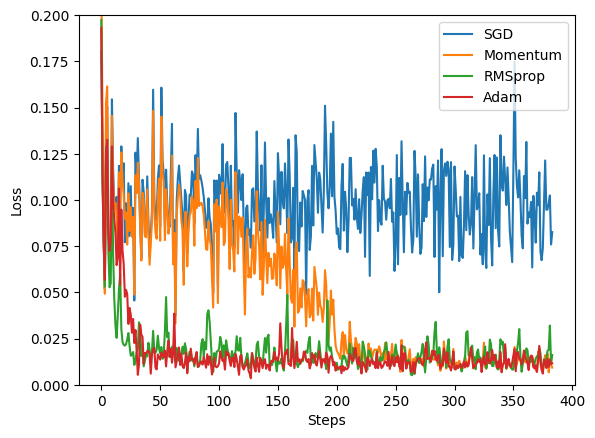

In [15]:
net_SGD = Net2()
net_Momentum = Net2()
net_RMSProp = Net2()
net_Adam = Net2()
nets = [net_SGD, net_Momentum, net_RMSProp, net_Adam]
opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.9)
opt_RMSProp = torch.optim.RMSprop(net_RMSProp.parameters(), lr=LR, alpha=0.9)
opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))
optimizers = [opt_SGD, opt_Momentum, opt_RMSProp, opt_Adam]
loss_func = torch.nn.MSELoss()
loss_his = [[], [], [], []] # 记录损失

for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader):
        for net, opt, l_his in zip(nets, optimizers, loss_his):
            output = net(batch_x) # get output for every net
            loss = loss_func(output, batch_y) # compute loss for every net
            opt.zero_grad() # clear gradients for next train
            loss.backward() # backpropagation, compute gradients
            opt.step() # apply gradients
            l_his.append(loss.data.numpy()) # loss recoder

labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']
for i, l_his in enumerate(loss_his):
    plt.plot(l_his, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 0.2))
plt.show()